In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Activation, Concatenate
from tensorflow.keras.layers import ReLU, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

from IPython import display
from PIL import Image
import time
import h5py

In [5]:
# print(tf.__version__)
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# # instantiate a distribution strategy
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [3]:
human_img_path = "../input/dataset-for-cyclegan/dataset_for_cyclegan/face"
anime_img_path = "../input/dataset-for-cyclegan/dataset_for_cyclegan/anime"
input_dir = "/kaggle/working/datatrain"
os.makedirs(input_dir, exist_ok=True)
output_dir = "/kaggle/working/Output"
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Image parameters
SEED_SIZE = 100
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 100
LAMBDA = 100
SAVE_FREQ = 20

In [5]:
# preprocess images
def preprocess_image(img_path):
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
    img = np.array(img, dtype=np.float32)
    img = (img - 127.5) / 127.5
    return img

In [6]:
# load and preprocess images
def load_and_preprocess_images(image_dir):
    images = []
    count = 0

    for filename in tqdm(sorted(os.listdir(image_dir))):
        if count >= 750 or count == len(os.listdir(image_dir)):
            break

        img_path = os.path.join(image_dir, filename)
        if os.path.isfile(img_path):
            img = preprocess_image(img_path)
            images.append(img)
            count+=1
    return np.array(images)

In [7]:
# Downsample and Upsample blocks
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

In [8]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

In [9]:
# Discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_image')
    
    down1 = downsample(64, 4, False)(inp)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    
    return Model(inputs=inp, outputs=last)

In [10]:
# Generator
def Generator():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # (bs, 256, 256, 3)
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    x = last(x)
    return Model(inputs=inputs, outputs=x)

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    return gan_loss, l1_loss
    
    
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

In [12]:
def train_step(real_human, real_style):
    with tf.GradientTape(persistent=True) as tape:
        fake_style = generator_style(real_human, training=True)
        cycled_human = generator_human(fake_style, training=True)

        fake_human = generator_human(real_style, training=True)
        cycled_style = generator_style(fake_human, training=True)

        disc_real_human = discriminator_human(real_human, training=True)
        disc_real_style = discriminator_style(real_style, training=True)

        disc_fake_human = discriminator_human(fake_human, training=True)
        disc_fake_style = discriminator_style(fake_style, training=True)

        # Generator loss
        gen_style_gan_loss, gen_style_l1_loss = generator_loss(disc_fake_style, fake_style, real_style)
        gen_human_gan_loss, gen_human_l1_loss = generator_loss(disc_fake_human, fake_human, real_human)

        total_cycle_loss = cycle_consistency_loss(real_human, cycled_human) + cycle_consistency_loss(real_style, cycled_style)

        total_gen_style_loss = gen_style_gan_loss + (LAMBDA * total_cycle_loss)
        total_gen_human_loss = gen_human_gan_loss + (LAMBDA * total_cycle_loss)

        # Discriminator loss
        disc_human_loss = discriminator_loss(disc_real_human, disc_fake_human)
        disc_style_loss = discriminator_loss(disc_real_style, disc_fake_style)

    # Calculate the gradients for generator and discriminator
    generator_style_gradients = tape.gradient(total_gen_style_loss,
                                                  generator_style.trainable_variables)
    generator_human_gradients = tape.gradient(total_gen_human_loss,
                                                  generator_human.trainable_variables)
    discriminator_human_gradients = tape.gradient(disc_human_loss,
                                                      discriminator_human.trainable_variables)
    discriminator_style_gradients = tape.gradient(disc_style_loss,
                                                      discriminator_style.trainable_variables)

    # Apply the gradients to the optimizer
    generator_style_optimizer.apply_gradients(zip(generator_style_gradients,
                                                      generator_style.trainable_variables))
    generator_human_optimizer.apply_gradients(zip(generator_human_gradients,
                                                      generator_human.trainable_variables))
    discriminator_human_optimizer.apply_gradients(zip(discriminator_human_gradients,
                                                          discriminator_human.trainable_variables))
    discriminator_style_optimizer.apply_gradients(zip(discriminator_style_gradients,
                                                          discriminator_style.trainable_variables))

    return total_gen_style_loss, total_gen_human_loss, disc_human_loss, disc_style_loss

In [13]:
# Training loop
def fit(train_ds, epochs, output_dir):
    for epoch in range(epochs): 
        start = time.time()

        total_gen_style_loss_list = []
        total_gen_human_loss_list = []
        disc_human_loss_list = []
        disc_style_loss_list = []

        for human_image, style_image in train_ds:
            total_gen_style_loss, total_gen_human_loss, disc_human_loss, disc_style_loss = train_step(human_image, style_image)

            total_gen_style_loss_list.append(total_gen_style_loss)
            total_gen_human_loss_list.append(total_gen_human_loss)
            disc_human_loss_list.append(disc_human_loss)
            disc_style_loss_list.append(disc_style_loss)

        # Tính toán loss trung bình cho mỗi epoch
        gen_style_loss_epoch = sum(total_gen_style_loss_list) / len(total_gen_style_loss_list)
        gen_human_loss_epoch = sum(total_gen_human_loss_list) / len(total_gen_human_loss_list)
        disc_human_loss_epoch = sum(disc_human_loss_list) / len(disc_human_loss_list)
        disc_style_loss_epoch = sum(disc_style_loss_list) / len(disc_style_loss_list)

        # Print losses for each epoch
        print(f'Epoch {epoch + 1}, '
                f'Gen Style Loss: {gen_style_loss_epoch}, '
                f'Gen Human Loss: {gen_human_loss_epoch}, '
                f'Disc Human Loss: {disc_human_loss_epoch}, '
                f'Disc Style Loss: {disc_style_loss_epoch}')

        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

        # Save checkpoint and images every SAVE_FREQ epochs
        if (epoch + 1) % SAVE_FREQ == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            example_human, example_style = next(iter(train_ds))
            save_images(generator_style, example_human, example_style, epoch + 1, output_dir)

In [14]:
# Function to save images
def save_images(generator, example_input, example_target, epoch, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    generated_images = generator(example_input, training=False)
    fig = plt.figure(figsize=(15, 15))
    
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(example_input[0] * 0.5 + 0.5)  # Rescale input image
    
    plt.subplot(1, 3, 2)
    plt.title('Generated Image')
    plt.imshow(generated_images[0] * 0.5 + 0.5)  # Rescale generated image
    
    plt.subplot(1, 3, 3)
    plt.title('Target Image')
    plt.imshow(example_target[0] * 0.5 + 0.5)  # Rescale target image
    
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f'image_at_epoch_{epoch}.png'))
    plt.close(fig)

In [15]:
# Generate sample images
def generate_sample_image(model, test_input):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [16]:
# Optimizers
generator_human_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_style_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_human_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_style_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [17]:
human_faces = load_and_preprocess_images(human_img_path)
style_faces = load_and_preprocess_images(anime_img_path)
# Create TensorFlow datasets
dataset = tf.data.Dataset.from_tensor_slices((human_faces, style_faces)).batch(BATCH_SIZE)

 12%|█▏        | 750/6035 [00:04<00:33, 158.71it/s]


In [18]:
# dataset = tf.data.Dataset.from_tensor_slices((human_faces, style_faces)).batch(1)

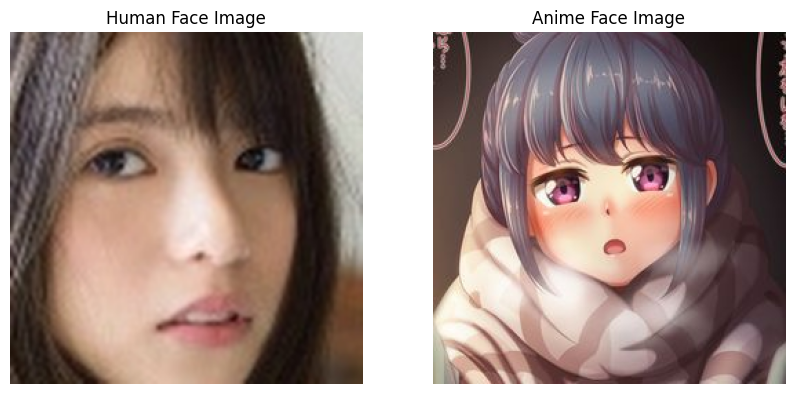

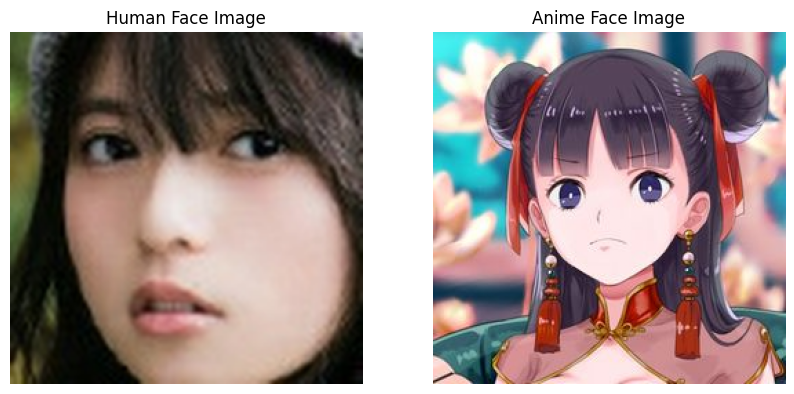

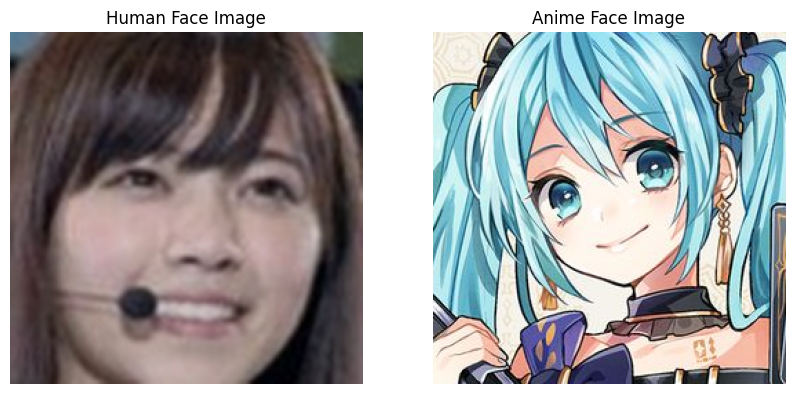

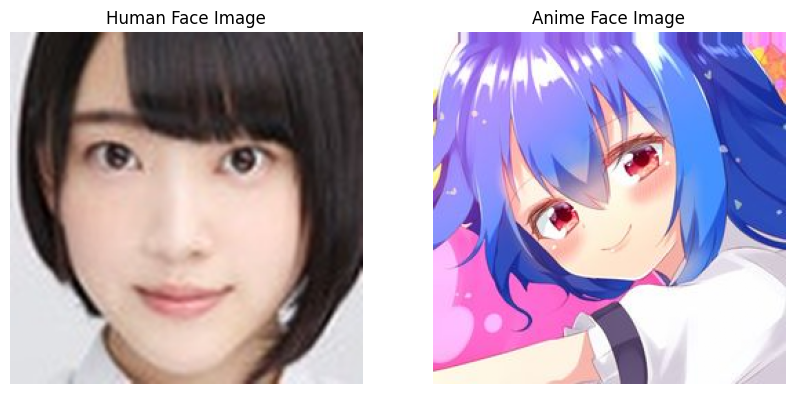

In [19]:
# Plot some examples
example_human, example_amine = next(iter(dataset))
def plot_images(example_human, example_anime, num_images=4):
    num_images = min(num_images, example_human.shape[0], example_anime.shape[0])
    
    for i in range(num_images):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Human Face Image')
        plt.imshow((example_human[i] * 0.5 + 0.5).numpy().astype(np.float32))  # De-normalize and display
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Anime Face Image')
        plt.imshow((example_anime[i] * 0.5 + 0.5).numpy().astype(np.float32))  # De-normalize and display
        plt.axis('off')
        
        plt.show()

plot_images(example_human, example_amine)

In [20]:
generator_human  = Generator()
generator_human.compile(loss='binary_crossentropy', optimizer=generator_human_optimizer)
generator_style  = Generator()
generator_style.compile(loss='binary_crossentropy', optimizer=generator_style_optimizer)
generator_human.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [21]:
discriminator_human  = Discriminator()
discriminator_human.compile(loss='binary_crossentropy', optimizer=discriminator_human_optimizer)
discriminator_style = Discriminator()
discriminator_style.compile(loss='binary_crossentropy', optimizer=discriminator_style_optimizer)
discriminator_human.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 64, 64, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 32, 32, 256)    │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 31, 31, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [22]:
# Directory for storing checkpoints
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Define the checkpoint
checkpoint = tf.train.Checkpoint(generator_human_optimizer=generator_human_optimizer,
                                 generator_style_optimizer=generator_style_optimizer,
                                 discriminator_human_optimizer=discriminator_human_optimizer,
                                 discriminator_style_optimizer=discriminator_style_optimizer,
                                 generator_human=generator_human,
                                 generator_style=generator_style,
                                 discriminator_human=discriminator_human,
                                 discriminator_style=discriminator_style)

In [ ]:
# Lists to store losses
total_gen_style_loss_list = []
total_gen_human_loss_list = []
disc_human_loss_list = []
disc_style_loss_list = []

fit(dataset, EPOCHS, output_dir)

Epoch 1, Gen Style Loss: 45.27492904663086, Gen Human Loss: 45.282718658447266, Disc Human Loss: 1.3058143854141235, Disc Style Loss: 1.3544371128082275
Time taken for epoch 1 is 125.1857647895813 sec

Epoch 2, Gen Style Loss: 26.16378402709961, Gen Human Loss: 26.399070739746094, Disc Human Loss: 0.9013436436653137, Disc Style Loss: 1.0448544025421143
Time taken for epoch 2 is 110.77392292022705 sec

Epoch 3, Gen Style Loss: 23.95793342590332, Gen Human Loss: 23.987398147583008, Disc Human Loss: 0.8688114285469055, Disc Style Loss: 0.8671931624412537
Time taken for epoch 3 is 111.26449465751648 sec

Epoch 4, Gen Style Loss: 22.56380844116211, Gen Human Loss: 22.664609909057617, Disc Human Loss: 0.7291834950447083, Disc Style Loss: 0.7996887564659119
Time taken for epoch 4 is 110.80095982551575 sec

Epoch 5, Gen Style Loss: 21.629121780395508, Gen Human Loss: 22.063047409057617, Disc Human Loss: 0.5878519415855408, Disc Style Loss: 0.7666479349136353
Time taken for epoch 5 is 110.92844

In [ ]:
os.makedirs('/kaggle/working/model', exist_ok=True)
generator_file = '/kaggle/working/model/stylegan_generator.h5'
generator_style.save(generator_file)

In [ ]:
output_dir = "/kaggle/working/output_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Lưu kiến trúc mô hình dưới dạng JSON
model_json = generator_style.to_json()
json_path = os.path.join(output_dir, "model_architecture.json")
with open(json_path, "w") as json_file:
    json_file.write(model_json)

# Lưu trọng số mô hình
weights_path = os.path.join(output_dir, "model_weights.weights.h5")
generator_style.save_weights(weights_path)

In [ ]:
def generate_and_save_images(model, test_input, output_dir, epoch):
    # Dự đoán ảnh tạo ra từ input
    prediction = model(test_input, training=False)

    # Hiển thị và lưu ảnh
    plt.figure(figsize=(15, 15))

    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(test_input[0] * 0.5 + 0.5)  # Rescale input image
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Generated Image')
    plt.imshow(prediction[0] * 0.5 + 0.5)  # Rescale generated image
    plt.axis('off')

    plt.savefig(os.path.join(output_dir, f'generated_image_at_epoch_{epoch}.png'))
    plt.show()

In [ ]:
test_image_path = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000019.jpg"
example_input = preprocess_image(test_image_path)
generate_and_save_images(generator_style, example_input, output_dir, epoch)